## Gender Based Violence - Tweet classification challenge 

This challenge aims to classify tweets about GBV without using keywords.

Are you able to develop a machine learning model that can classify a tweet about gender-based violence into either of the five categories:
- Sexual violence
- Emotional violence
- Economic violence
- Physical violence
- Harmful traditional practice


### Install modules/package

In [2]:
# !pip install -U nltk #natural language toolkit

### import libraries/modules

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### load the dataset

In [4]:
train = pd.read_csv("Train.csv")

In [5]:
train.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [6]:
train.isnull().sum()

Tweet_ID    0
tweet       0
type        0
dtype: int64

In [7]:
train.shape

(39650, 3)

In [8]:
train['tweet'][7688]

'The cops told me "your husband raped you a week ago? why are you crying?" When they eventually did take an information-only report for misdemeanor battery, they mailed a copy to our address. He found it in the mail. The cops put me in MORE danger than if I had said nothing.'

# Cleaning data

In [10]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
def clean(text):
    text=text.lower()
    text=re.sub('[-+]?[0-9]+','',text)
    text=re.sub('\[[^]]*\]','',text)
    text=re.sub(r'[^\w\s]','',text)
#     text=text.split()
#     tok=word_tokenize
#     text=tok.tokenize(text)
    return text
# train['tweet'].apply(lambda x: [item for item in x if item not in stop])
train['clean']=train['tweet'].apply(clean)

In [11]:
train['tweet'][31468]

'Happy ! To celebrate, my husband took me to see and I LOVED it! I was so absorbed I even forgot to watch for the beats!'

In [12]:
train['clean'][31468]

'happy  to celebrate my husband took me to see and i loved it i was so absorbed i even forgot to watch for the beats'

In [13]:
train['clean'].apply(lambda x: [item for item in x if item not in stop])


0        [h,  ,  , r, e,  ,  , g,  , r, p, e,  , l,  , ...
1        [h, e,  , h, u, g, h,  , h, e,  , w, r,  , r, ...
2        [h, e,  , n,  , l, k, n, g,  ,  , e,  ,  , w, ...
3        [ , w,  , e, x, u, l, l,  , b, u, e,  , f, r, ...
4        [c, h, e,  , p, r, u,  , c, n,  ,  , b, e, e, ...
                               ...                        
39645    [e, n, r,  ,  , f,  ,  , b, f,  , c, u, n,  , ...
39646    [ , u, r, e,  , e, l, l, n, g,  , e,  , e, n, ...
39647    [ , w, f, e,  , r, e, g, u, l, r, l,  , b, e, ...
39648    [e,  , h, e,  , b, b, e,  , p, l, c, e,  , f, ...
39649    [ , w, l, l,  , k, e,  , c, c, u, n, b, l,  , ...
Name: clean, Length: 39650, dtype: object

In [14]:
test = pd.read_csv("Test.csv")

In [15]:
test.head()

,Tweet_ID,tweet
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,..."
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l..."
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...
3,ID_00G9OSKZ,University of Cape Coast students being robbed...
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i..."


In [16]:
test['clean']=test['tweet'].apply(clean)

In [17]:
test['clean'].apply(lambda x: [item for item in x if item not in stop])

0        [b, e, c, u, e,  , h, e,  , w,  ,  , b, f, r, ...
1        [l, l,  , n,  ,  , e, l, l, n, g,  , u,  ,  , ...
2        [l,  , e, u, n, u,  , p, u, n, l, n,  , r, e, ...
3        [u, n, v, e, r,  , f,  , c, p, e,  , c,  , u, ...
4        [e, b,  , c, e,  , u, p,  , b, e, h, n,  , h, ...
                               ...                        
15576    [ , e, e, e,  , c, h, r,  , h,  , f, l, e,  , ...
15577    [h, e,  ,  , f, r, c, e,  , e,  ,  , h, v, e, ...
15578    [f, e, l, e,  , u, e, n,  , f,  , e, c, l,  , ...
15579    [b, k,  , p, e, b, e,  ,  , n, h,  , k, n, p, ...
15580    [c, n, f, e, n,  , n, e, v, e, r,  , r, e, l, ...
Name: clean, Length: 15581, dtype: object

### EDA

In [18]:
train.shape # the training dataset has 39650 rows

(39650, 4)

In [19]:
train["type"].unique()

array(['sexual_violence', 'Physical_violence', 'emotional_violence',
       'Harmful_Traditional_practice', 'economic_violence'], dtype=object)

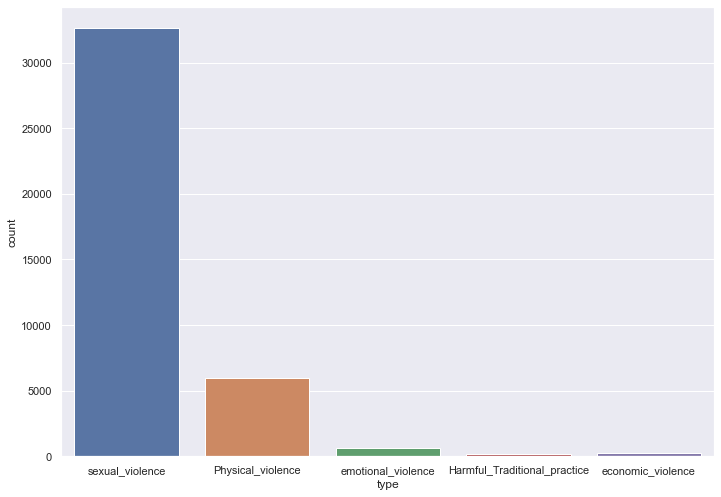

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(train["type"])

This dataset is highly imbalanced; from the graphs above, sexual violence is about 80%+. 

In [21]:
test.shape # the test dataset has 15581 rows

(15581, 3)

### Create models

Before we develop our models, we can set aside some validation dataset for inference purposes. We'll use scikit learn train test split module.https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [22]:
X = train.drop(["type",'tweet',"Tweet_ID"], axis=1)
y = train["type"]

In [23]:
from imblearn.over_sampling import RandomOverSampler
over=RandomOverSampler(random_state=56)
X_over,y_over=over.fit_resample(X,y)

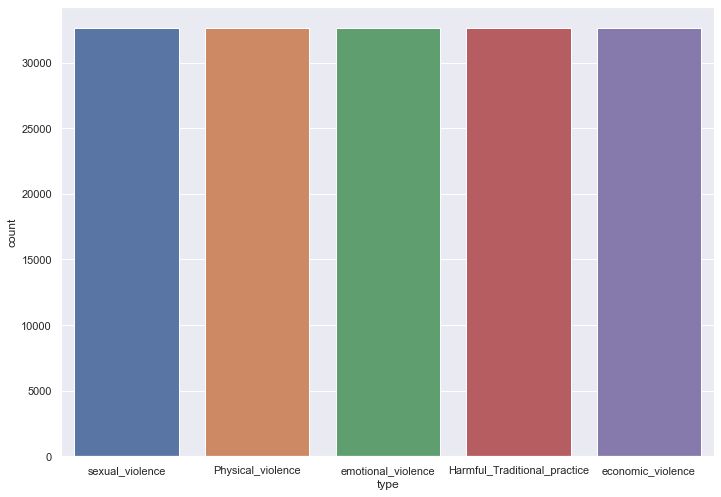

In [24]:
sns.countplot(y_over)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=42)

CountVectorizer -converts text files/data into numerical feature vectors. You can find more information on CountVectorizer  here  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [26]:
vectorizer = CountVectorizer()

# fit_transform our tweets values to numerical vectors
x_train_counts = vectorizer.fit_transform(X_train["clean"])
x_train_counts

<122430x37044 sparse matrix of type '<class 'numpy.int64'>'
	with 3470149 stored elements in Compressed Sparse Row format>

In [27]:
print(vectorizer.get_feature_names())

['__', '___', '____', '_____', '______', '_____________', '_______________', '__________me', '_my_', '_such_', '_x', '_ツ_', 'aa', 'aaa', 'aaaaa', 'aaaaall', 'aaaaand', 'aaaahahahahahahahahahahhhhahah', 'aaaand', 'aaaanyfuckersi', 'aaargh', 'aaarrhg', 'aachen', 'aachi', 'aafia', 'aag', 'aagbek', 'aahh', 'aaj', 'aajtak', 'aaliyah', 'aam', 'aampm', 'aampt', 'aanandi', 'aand', 'aane', 'aap', 'aapni', 'aaron', 'aasiya', 'aata', 'aati', 'aault', 'aawe', 'aaww', 'aaya', 'aayog', 'aazhibikoong', 'ab', 'abacha', 'abadan', 'abali', 'abancane', 'abandon', 'abandoned', 'abandonned', 'abantwana', 'abaranje', 'abashana', 'abatwa', 'abba', 'abbas', 'abbey', 'abbie', 'abbiethe', 'abbott', 'abbotts', 'abby', 'abc', 'abcdxyz', 'abcess', 'abd', 'abdandon', 'abdelaziz', 'abdou', 'abduct', 'abducted', 'abductedgot', 'abductedraped', 'abduction', 'abductor', 'abducts', 'abdul', 'abdulkareem', 'abdullah', 'abdulrazak', 'abe', 'abebty', 'abedin', 'abeg', 'abegg', 'abegiii', 'abery', 'abetz', 'abhi', 'abhilash

Using the CountVectorizer is effective, but this might give more preference to longer tweets than others. Let's try using frequencies. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [28]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_train_tfidf.shape

(122430, 37044)

Multiple algorithms are used for text classification; let’s look at:-

### 1. Naive Bayes MultinomialNB https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [29]:
from sklearn.ensemble import RandomForestClassifier


In [30]:
# # train.type.values our y values
# clf = Pipeline([('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
#                   ('clf', MultinomialNB())])
# clf = clf.fit(X_train["clean"], y_train)

In [37]:
# stacking classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# st=StackingClassifier(estimators=[KNeighborsClassifier(n_neighbors=5),LogisticRegression(),
#                                   RandomForestClassifier()],final_estimator=RandomForestClassifier())

    
clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression())])
clf = clf.fit(X_train["clean"], y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
# # train.type.values our y values
# clf = Pipeline([('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
#                   ('clf', st)])
# clf = clf.fit(X_train["clean"], y_train)

### evaluation metric
The evaluation metric on the Zindi leaderboard is accuracy; let’s test our simple model,

In [39]:
predicted = clf.predict(X_test.clean)

In [40]:
predicted

array(['emotional_violence', 'Harmful_Traditional_practice',
       'sexual_violence', ..., 'economic_violence', 'sexual_violence',
       'Harmful_Traditional_practice'], dtype=object)

In [41]:
np.unique(predicted)

array(['Harmful_Traditional_practice', 'Physical_violence',
       'economic_violence', 'emotional_violence', 'sexual_violence'],
      dtype=object)

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predicted)

0.9998529772114678

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted))

                              precision    recall  f1-score   support

Harmful_Traditional_practice       1.00      1.00      1.00      8166
           Physical_violence       1.00      1.00      1.00      8016
           economic_violence       1.00      1.00      1.00      8363
          emotional_violence       1.00      1.00      1.00      8213
             sexual_violence       1.00      1.00      1.00      8052

                    accuracy                           1.00     40810
                   macro avg       1.00      1.00      1.00     40810
                weighted avg       1.00      1.00      1.00     40810



- Our simple model gave us an accuracy score of 88%, fair enough, but you should also be careful that the data is highly imbalanced, as discussed earlier. 

- Question? Is the imbalance percentage the same as in the test? Can you think of various ways to deal with the imbalance dataset

- We can also see the only 3 categories(i.e 'Physical_violence', 'emotional_violence', 'sexual_violence') were predicted yet we have 5 categories. Therefore 88% might not be that good.


### submission

In [44]:
sample_submission = pd.read_csv("SampleSubmission.csv")

In [45]:
sample_submission.head()

,Tweet_ID,type
0,ID_0095QL4S,NaN
1,ID_00DREW5O,NaN
2,ID_00E9F5X9,NaN
3,ID_00G9OSKZ,NaN
4,ID_00HU96U6,NaN


In [46]:
##let's prdict on the test data
test_predict = clf.predict(test.tweet)

In [47]:
test_predict

array(['sexual_violence', 'Harmful_Traditional_practice',
       'Harmful_Traditional_practice', ..., 'sexual_violence',
       'sexual_violence', 'sexual_violence'], dtype=object)

In [48]:
np.unique(test_predict)

array(['Harmful_Traditional_practice', 'Physical_violence',
       'economic_violence', 'emotional_violence', 'sexual_violence'],
      dtype=object)

In [49]:
sample_submission["type"] = test_predict

In [50]:
sample_submission.to_csv('b2.csv', index=False)

### To do,
- Do more analysis
- Try working on ways to balance the dataset, undersampling, oversampling, using SMOTE, etc
- You can try other text classification models, e.g., using nltk, etc.
